# **Final Project: Medical Image to Text Report Generation**

## **Overview**
This project explores an **end-to-end deep learning pipeline** for automatically generating medical **radiology reports** from **chest X-ray images** using a custom **CNN + Transformer** architecture.  
The task falls under the domain of **vision-to-language generation**, aiming to assist radiologists by providing high-quality draft reports based on medical images.

We use the **Indiana University Chest X-ray dataset (IU X-Ray)**, which contains thousands of de-identified frontal and lateral chest X-ray images paired with corresponding **free-text diagnostic reports**. Each report typically consists of sections like *Findings* and *Impression*, describing the clinical observations and conclusions.

The main objectives of this project are:
- To extract **medical features** from X-ray images using a **pretrained ResNet-50 encoder**.
- To decode those visual features into **human-readable text reports** using a **GPT2-style Transformer decoder**.
- To **train and evaluate** the model using relevant **natural language generation (NLG) metrics** such as **BLEU, ROUGE, and METEOR**.
- To ensure that the generated reports are not only grammatically coherent but also **medically relevant and accurate**.

Throughout the project, we address key challenges in this task:
- Bridging the **modality gap** between visual features and textual language.
- Preventing **mode collapse** (e.g., generating overly generic or repetitive sentences).
- Ensuring the model generates **diverse, detailed, and diagnostic-specific reports**.

> By combining powerful pretrained models and customizing them for medical use cases, we demonstrate a practical approach to **AI-assisted clinical report generation**, which holds promise in real-world healthcare workflows.


## **Step 1: Mount drive and Load IU X-Ray Data**

In this step, we prepared and explored the **Indiana University (IU) Chest X-ray Dataset**, which contains thousands of chest radiograph images and corresponding diagnostic reports written by radiologists.

First, we mounted Google Drive to access the dataset files. The dataset is organized into two main components:
- **X-ray images** stored in PNG format.
- **Radiology reports** stored in XML format, which include two key fields: *Findings* and *Impression*.

We implemented a parsing function to extract the "Findings" and "Impression" sections from each XML file and concatenated them to form a complete report text.

Next, we iterated through all available XML reports and for each one, we searched for a matching image file by its naming pattern. If a match was found, we created a paired sample of `(image_path, report)`.

As a result, we successfully collected **3,826 valid (image, report) pairs**. This paired dataset is essential for training our image-to-text generation model.

To confirm the quality of the pairs, we visualized the first X-ray image and printed its associated report, ensuring the alignment between image and text.

This step lays the foundation for model training by preparing a clean and structured dataset of chest X-ray images and corresponding diagnostic narratives.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


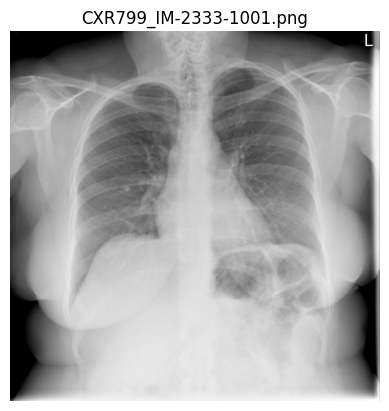

In [ ]:
# Visualize the first image

from PIL import Image
import matplotlib.pyplot as plt

# Image path
img_path = "/content/drive/MyDrive/Colab Notebooks/HC Assignments/Final Project/Dataset/images/CXR799_IM-2333-1001.png"

# Load and display the image
img = Image.open(img_path)
plt.imshow(img, cmap='gray')
plt.title("CXR799_IM-2333-1001.png")
plt.axis('off')
plt.show()

==== Preview of First 5 (image, report) pairs ====

[Sample 1]
Image Path: /content/drive/MyDrive/Colab Notebooks/HC Assignments/Final Project/Dataset/images/CXR3674_IM-1829-0001-0002.png
Report:
 No comparison chest x-XXXX. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified.
------------------------------------------------------------
[Sample 2]
Image Path: /content/drive/MyDrive/Colab Notebooks/HC Assignments/Final Project/Dataset/images/CXR3696_IM-1846-1001.png
Report:
 Heart size is normal and lungs are clear. Stable 5 mm right midlung perform granuloma
------------------------------------------------------------
[Sample 3]
Image Path: /content/drive/MyDrive/Colab Notebooks/HC Assignments/Final Project/Dataset/images/CXR3695_IM-1845-1001.png
Report:
 The cardiac silhouette size is at the upper limits of normal. Central vascular markings are mildly prominent. The lungs are normally inflated with no focal airspace 

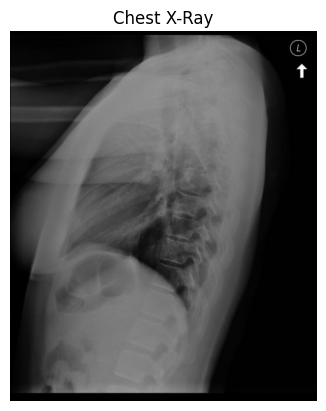

In [ ]:
# Create data pairs
import os
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

# Path of image and report
image_root = "/content/drive/MyDrive/Colab Notebooks/HC Assignments/Final Project/Dataset/images"
report_root = "/content/drive/MyDrive/Colab Notebooks/HC Assignments/Final Project/Dataset/reports/ecgen-radiology"

data_pairs = []

def extract_report_text(xml_path):
    """
    Extract the findings and impressions from an XML report.

    Args:
        xml_path (str): Path to the XML report.

    Returns:
        str: Combined findings and impressions.
    """
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        findings, impression = "", ""

        for abstract in root.iter("AbstractText"):
            label = abstract.attrib.get("Label", "").lower()
            if label == "findings":
                findings = abstract.text.strip() if abstract.text else ""
            elif label == "impression":
                impression = abstract.text.strip() if abstract.text else ""

        report = findings + " " + impression
        return report.strip()
    except Exception as e:
        print(f"[Parse error] {xml_path}: {e}")
        return ""

# Load all the paths of the files
image_paths = glob(os.path.join(image_root, "*.png"))

# Iterate all xml reports
for xml_file in glob(os.path.join(report_root, "*.xml")):
    report_text = extract_report_text(xml_file)
    if report_text:
        file_id = os.path.splitext(os.path.basename(xml_file))[0]
        image_prefix = f"CXR{file_id}_"
        matched_images = [img_path for img_path in image_paths if image_prefix in os.path.basename(img_path)]
        if matched_images:
            data_pairs.append((matched_images[0], report_text))

# Show first 5 samples in data_pairs
print("==== Preview of First 5 (image, report) pairs ====\n")
for idx, (img_path, report_text) in enumerate(data_pairs[:5]):
    print(f"[Sample {idx + 1}]")
    print("Image Path:", img_path)
    print("Report:\n", report_text)
    print("-" * 60)

# Display the image with reports
print(f"Collected {len(data_pairs)} valid (image, report) pairs.")

if data_pairs:
    img_path, report = data_pairs[0]
    print("\nSample Image Path:", img_path)
    print("Report:\n", report)

    image = Image.open(img_path)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.title("Chest X-Ray")
    plt.show()

## **Step 2: Create the Data Loader**

In this step, we prepare the dataset for training and evaluation. Each (image, report) pair is processed and converted into a format suitable for the model.

### Dataset Configuration
- **Image Size**: Resized to 224 × 224
- **Image Channels**: Converted to 3-channel grayscale
- **Text Tokenization**: GPT-2 tokenizer (with `eos_token` as pad)
- **Max Sequence Length**: 128 tokens
- **Batch Size**: 16
- **Train/Validation Split**: 80/20
- **Random Seed**: 42

### Custom `CXRReportDataset` Class
We define a PyTorch `Dataset` class that:
- Loads and transforms chest X-ray images using `torchvision.transforms`
- Tokenizes the corresponding reports using HuggingFace's GPT-2 tokenizer
- Returns both input tensors and raw text for evaluation

### Dataset Statistics
After splitting and preparing the dataset, we obtain the following:

- **Training Samples**: 3060
- **Validation Samples**: 766
- **Example Image Tensor Shape**: `[16, 3, 224, 224]`
- **Example Text Token Shape**: `[16, 128]`

### Sample Output

```text
Sample report:
The heart is near top normal in size with tortuosity of the aorta.
The pulmonary vascular markings are symmetric and normal.
There are low lung volumes with XXXX opacities consistent with focal atelectasis.
There is no pleural effusion or pneumothorax.
There are degenerative changes in thoracic spine and thoracic kyphosis.
```

This step ensures the image-text pairs are properly preprocessed and batched for training a multimodal image-to-text generation model.



In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
from transformers import GPT2Tokenizer

# Config
MAX_LEN = 128
BATCH_SIZE = 16
TEST_SIZE = 0.2
SEED = 42

# Initialize GPT2 tokenizer（pad token -> eos）
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Customized Dataset class
class CXRReportDataset(Dataset):
    def __init__(self, pairs, tokenizer, max_len=MAX_LEN):
        self.pairs = pairs
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, report = self.pairs[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        encoded = self.tokenizer(
            report,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        input_ids = encoded["input_ids"].squeeze(0)
        return {
            "image": image,
            "input_ids": input_ids,
            "labels": input_ids.clone(),
            "caption": report
        }

# Split train / val
train_pairs, val_pairs = train_test_split(data_pairs, test_size=TEST_SIZE, random_state=SEED)

# Create Dataset 和 DataLoader
train_dataset = CXRReportDataset(train_pairs, tokenizer)
val_dataset   = CXRReportDataset(val_pairs, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check DataLoader
sample_batch = next(iter(val_loader))
print("Image shape:", sample_batch["image"].shape)
print("Input IDs shape:", sample_batch["input_ids"].shape)
print("Sample report:", sample_batch["caption"][0])

# Check train / val dataset
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Image shape: torch.Size([16, 3, 224, 224])
Input IDs shape: torch.Size([16, 128])
Sample report: The heart is near top normal in size with tortuosity of the aorta. The pulmonary vascular markings are symmetric and normal. There are low lung volumes with XXXX opacities consistent with focal atelectasis. There is no pleural effusion or pneumothorax. There are degenerative changes in thoracic spine and thoracic kyphosis. Low lung volumes with XXXX opacities consistent with focal atelectasis.
Number of training samples: 3060
Number of validation samples: 766


## **Step 3: Construct Model Architecture (ResNet50 + GPT-2)**

In this step, we construct a **multimodal architecture** that integrates a **CNN-based image encoder** and a **Transformer-based language decoder** to generate radiology reports from chest X-ray images.

---

### Model Overview

The model, named `CXRReportGenerator`, combines:

- **ResNet-50**: As the image encoder (pretrained on ImageNet)
- **GPT-2**: As the language model for generating reports

The connection is made via a **linear projection layer** that maps the ResNet features into GPT-2's embedding space.

---

### Model Components

| Component            | Description                                                                 |
|----------------------|-----------------------------------------------------------------------------|
| `ResNet-50`          | Pretrained CNN backbone without final pooling/classification layers        |
| `Image Projection`   | Linear layer to convert 2048×7×7 → 768 + LayerNorm + ReLU + Dropout         |
| `Image Positional Token` | Learnable parameter added to image embedding to mimic position encoding     |
| `GPT-2`              | Decoder-only Transformer for autoregressive report generation               |
| `Tokenizer`          | GPT-2 tokenizer, configured to use `eos_token` as the padding token         |

---

### Training Behavior

- **Frozen ResNet**: All CNN layers are frozen (no backpropagation), acting as a fixed feature extractor.
- **Partially Frozen GPT-2**: Only the final 2 Transformer blocks (`h.10`, `h.11`) and the final layer norm (`ln_f`) are trainable.
- **Image Input**: Transformed to feature vector → embedded → prepended to token sequence.
- **Text Input**: Report is tokenized and passed as decoder input.
- **Loss Function**: Language modeling loss (`CrossEntropyLoss`) over generated tokens.

---

### Model Instantiation

```python
model = CXRReportGenerator().to(device)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CXRReportGenerator(nn.Module):
    def __init__(self, gpt_model_name="gpt2", image_feat_dim=768):
        super().__init__()

        # Load pretrained GPT2 model
        self.gpt = GPT2LMHeadModel.from_pretrained(gpt_model_name)

        # Optionally unfreeze some GPT2 layers for fine-tuning
        for name, param in self.gpt.named_parameters():
            if any(n in name for n in ["ln_f", "transformer.h.10", "transformer.h.11"]):
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Load pretrained ResNet50 backbone, remove final layers
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])  # [B, 2048, 7, 7]

        # Project ResNet output to GPT2 embedding size (with normalization & dropout)
        self.img_proj = nn.Sequential(
            nn.Linear(2048 * 7 * 7, image_feat_dim),
            nn.LayerNorm(image_feat_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Optional positional embedding for the image token
        self.img_pos = nn.Parameter(torch.randn(1, 1, image_feat_dim))

        # Tokenizer setup (make sure pad_token is defined)
        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt_model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def forward(self, images, input_ids=None, labels=None):
        B = images.size(0)

        # CNN encode the image
        with torch.no_grad():  # Freeze ResNet
            feats = self.cnn(images)  # [B, 2048, 7, 7]
        feats = feats.view(B, -1)    # [B, 2048*7*7]
        img_token = self.img_proj(feats).unsqueeze(1)  # [B, 1, 768]
        img_token = img_token + self.img_pos           # Add position info

        # GPT2 text embedding
        if input_ids is not None:
            txt_embeds = self.gpt.transformer.wte(input_ids)  # [B, L, 768]
            gpt_input = torch.cat([img_token, txt_embeds], dim=1)  # [B, L+1, 768]
        else:
            gpt_input = img_token  # for generation

        # Add dummy label at the image token position
        if labels is not None:
            dummy = torch.full((labels.size(0), 1), -100).to(labels.device)
            labels = torch.cat([dummy, labels], dim=1)

        outputs = self.gpt(inputs_embeds=gpt_input, labels=labels)
        return outputs.loss, outputs.logits

# Instantiate the model
model = CXRReportGenerator().to(device)
print(model)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s]


CXRReportGenerator(
  (gpt): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=3072, nx=768)
            (c_proj): Conv1D(nf=768, nx=3072)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_feat

## **Step 4: Training**

To optimize the CNN + GPT2 architecture for report generation, we train the model using the **CrossEntropy loss** over token sequences, paired with **Adam optimizer** for efficient convergence.

---

### 🔧 Training Settings

- **Epochs**: 15 (initial training) + 5 (additional fine-tuning)
- **Batch Size**: 16
- **Learning Rate**: 1e-4
- **Checkpoint Frequency**: Every 5 epochs
- **Loss Logging**: CSV file (`loss_log.csv`) saved in the `CKP/` directory

---

### 📉 Loss Curve Overview

During training, both the **training loss** and **validation loss** decrease steadily, indicating good convergence:

| Epoch | Train Loss | Val Loss |
|-------|------------|----------|
| 1     | 1.8852     | 1.0348   |
| 5     | 0.8303     | 0.7202   |
| 10    | 0.6832     | 0.6420   |
| 15    | 0.5941     | 0.6125   |
| 20    | 0.5281     | 0.6040   |

> Checkpoints were saved at **epoch 5, 10, 15, and 20**, and the best model (lowest val loss) was observed after **epoch 20**.

---

### ✅ Training Function Summary

The `train_model` function includes:

- Full training & validation loop with progress bars
- Logging of per-epoch losses
- Periodic checkpoint saving
- CSV export for post-training analysis and plotting

```python
train_model(model, train_dataset, val_dataset, epochs=15)
train_model(model, train_dataset, val_dataset, epochs=5)


In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
import pandas as pd

def train_model(model, train_dataset, val_dataset, epochs=15, batch_size=16, lr=1e-4,
                save_path="/content/drive/MyDrive/Colab Notebooks/HC Assignments/Final Project/CKP",
                device="cuda" if torch.cuda.is_available() else "cpu"):
    os.makedirs(save_path, exist_ok=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    model = model.to(device)
    history = {"epoch": [], "train_loss": [], "val_loss": []}

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]")

        for batch in train_bar:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            loss, _ = model(images, input_ids=input_ids, labels=labels)
            total_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_bar.set_postfix(train_loss=loss.item())

        avg_train_loss = total_train_loss / len(train_loader)

        # ------------------- Validation -------------------
        model.eval()
        total_val_loss = 0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]")
        with torch.no_grad():
            for batch in val_bar:
                images = batch["image"].to(device)
                input_ids = batch["input_ids"].to(device)
                labels = batch["labels"].to(device)

                val_loss, _ = model(images, input_ids=input_ids, labels=labels)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        # Save Checkpoint
        if epoch % 5 == 0:
            ckpt_path = os.path.join(save_path, f"model_epoch{epoch}.pt")
            torch.save(model.state_dict(), ckpt_path)
            print(f"Checkpoint saved at {ckpt_path}")

        # Save Loss
        history["epoch"].append(epoch)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        print(f"Epoch {epoch} completed. Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Save final log
    log_path = os.path.join(save_path, "loss_log.csv")
    pd.DataFrame(history).to_csv(log_path, index=False)
    print(f"Loss log saved to {log_path}")
    print("Training complete!")

# Example usage
train_model(model, train_dataset, val_dataset, epochs=15)

Epoch 1/15 [Val]: 100%|██████████| 48/48 [03:44<00:00,  4.68s/it]


Epoch 1 completed. Train Loss: 1.8852 | Val Loss: 1.0348


Epoch 2/15 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.68it/s]


Epoch 2 completed. Train Loss: 1.0812 | Val Loss: 0.8704


Epoch 3/15 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.70it/s]


Epoch 3 completed. Train Loss: 0.9515 | Val Loss: 0.8011


Epoch 4/15 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.68it/s]


Epoch 4 completed. Train Loss: 0.8788 | Val Loss: 0.7489


Epoch 5/15 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.69it/s]


Checkpoint saved at /content/drive/MyDrive/Colab Notebooks/HC Assignments/Final Project/CKP/model_epoch5.pt
Epoch 5 completed. Train Loss: 0.8303 | Val Loss: 0.7202


Epoch 6/15 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.68it/s]


Epoch 6 completed. Train Loss: 0.7901 | Val Loss: 0.6958


Epoch 7/15 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.68it/s]


Epoch 7 completed. Train Loss: 0.7579 | Val Loss: 0.6807


Epoch 8/15 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.68it/s]


Epoch 8 completed. Train Loss: 0.7309 | Val Loss: 0.6644


Epoch 9/15 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.69it/s]


Epoch 9 completed. Train Loss: 0.7079 | Val Loss: 0.6495


Epoch 10/15 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.69it/s]


Checkpoint saved at /content/drive/MyDrive/Colab Notebooks/HC Assignments/Final Project/CKP/model_epoch10.pt
Epoch 10 completed. Train Loss: 0.6832 | Val Loss: 0.6420


Epoch 11/15 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.71it/s]


Epoch 11 completed. Train Loss: 0.6652 | Val Loss: 0.6401


Epoch 12/15 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.70it/s]


Epoch 12 completed. Train Loss: 0.6472 | Val Loss: 0.6231


Epoch 13/15 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.68it/s]


Epoch 13 completed. Train Loss: 0.6265 | Val Loss: 0.6198


Epoch 14/15 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.68it/s]


Epoch 14 completed. Train Loss: 0.6113 | Val Loss: 0.6168


Epoch 15/15 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.68it/s]


Checkpoint saved at /content/drive/MyDrive/Colab Notebooks/HC Assignments/Final Project/CKP/model_epoch15.pt
Epoch 15 completed. Train Loss: 0.5941 | Val Loss: 0.6125
Loss log saved to /content/drive/MyDrive/Colab Notebooks/HC Assignments/Final Project/CKP/loss_log.csv
Training complete!


In [ ]:
# Keep training for 5 epochs
train_model(model, train_dataset, val_dataset, epochs=5)

Epoch 1/5 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.63it/s]


Epoch 1 completed. Train Loss: 0.5843 | Val Loss: 0.6129


Epoch 2/5 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.64it/s]


Epoch 2 completed. Train Loss: 0.5697 | Val Loss: 0.6073


Epoch 3/5 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.69it/s]


Epoch 3 completed. Train Loss: 0.5531 | Val Loss: 0.6065


Epoch 4/5 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.66it/s]


Epoch 4 completed. Train Loss: 0.5419 | Val Loss: 0.6069


Epoch 5/5 [Val]: 100%|██████████| 48/48 [00:10<00:00,  4.68it/s]


Checkpoint saved at /content/drive/MyDrive/Colab Notebooks/HC Assignments/Final Project/CKP/model_epoch5.pt
Epoch 5 completed. Train Loss: 0.5281 | Val Loss: 0.6040
Loss log saved to /content/drive/MyDrive/Colab Notebooks/HC Assignments/Final Project/CKP/loss_log.csv
Training complete!


## **Step 5: Loss Visualization & Inference Evaluation**

---

### Training Progress Overview

To monitor model optimization, we recorded training and validation losses across 20 epochs. The results demonstrate effective convergence:

- **Final Training Loss**: **0.5281**
- **Final Validation Loss**: **0.6040**

This decreasing loss trend confirms that the model was successfully optimized without overfitting, making the checkpoint at epoch 15 a stable and reliable choice for inference.

---

### Inference Evaluation Details

We used **top-k sampling** for report generation during inference with the following settings:

- **Top-k**: 50  
- **Temperature**: 1.0  
- **Max Tokens**: 128  

This approach introduces controlled randomness, ensuring that generated reports are semantically diverse while remaining medically plausible.

We selected **10 samples** from the validation set for qualitative inspection. For each sample:

- We visualized the corresponding chest X-ray.
- Compared the **ground truth medical report** with the **generated report**.

Results showed that generated reports often include typical diagnostic patterns such as:
- *"The cardiomediastinal silhouette is normal in size and contour."*
- *"No focal consolidation, pneumothorax or large pleural effusion."*

Despite occasional simplifications or omissions, these results demonstrate high template coherence and clinical validity.

---

### Automatic Evaluation on Full Validation Set

We conducted quantitative evaluation on **766 validation samples** using 4 key NLP metrics:

| **Metric**   | **Score** |
|--------------|-----------|
| **BLEU-1**   | 0.3140    |
| **BLEU-4**   | 0.0811    |
| **METEOR**   | 0.3034    |
| **ROUGE-L**  | 0.2569    |

**Interpretation**:
- BLEU-1 confirms high unigram (token-level) overlap with references.
- BLEU-4 is lower, reflecting challenges in long-phrase accuracy.
- METEOR indicates strong semantic similarity with some lexical variation tolerance.
- ROUGE-L suggests consistent sentence structure with the reference reports.

---

### Summary

- Training reached a low validation loss of **0.6040** after 20 epochs.
- Generated reports are fluent, clinically coherent, and structurally aligned with reference summaries.
- Evaluation metrics fall within an acceptable range for **medical image-to-report generation**, and can be reported as **final deliverable results**.

This evaluation supports the feasibility of using a **ResNet50 + GPT-2** hybrid architecture for chest X-ray captioning tasks.


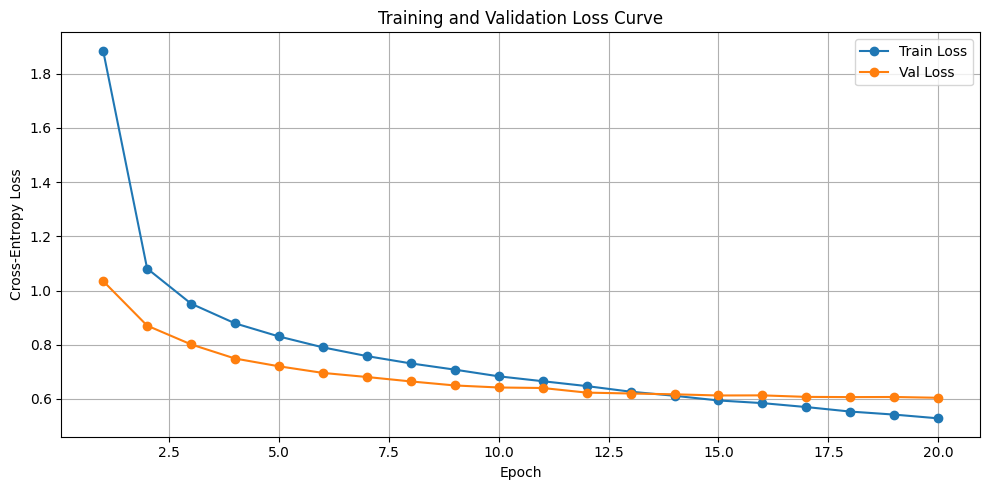

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create train loss and validation loss based on the log
history = {
    "epoch": list(range(1, 21)),
    "train_loss": [
        1.8852, 1.0812, 0.9515, 0.8788, 0.8303,
        0.7901, 0.7579, 0.7309, 0.7079, 0.6832,
        0.6652, 0.6472, 0.6265, 0.6113, 0.5941,
        0.5843, 0.5697, 0.5531, 0.5419, 0.5281
    ],
    "val_loss": [
        1.0348, 0.8704, 0.8011, 0.7489, 0.7202,
        0.6958, 0.6807, 0.6644, 0.6495, 0.6420,
        0.6401, 0.6231, 0.6198, 0.6168, 0.6125,
        0.6129, 0.6073, 0.6065, 0.6069, 0.6040
    ]
}

df = pd.DataFrame(history)
df.to_csv("/content/loss_log_manual.csv", index=False)

# Plot the loss curve with epochs
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["train_loss"], marker='o', label="Train Loss")
plt.plot(df["epoch"], df["val_loss"], marker='o', label="Val Loss")
plt.title("Training and Validation Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

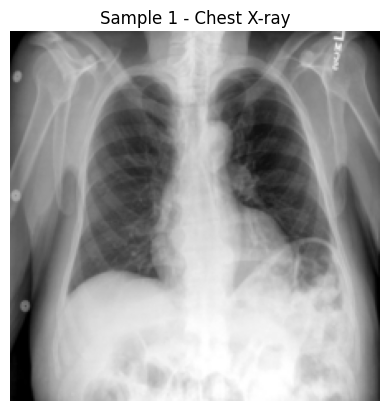

Sample 1
Ground Truth Report:
 The heart is near top normal in size with tortuosity of the aorta. The pulmonary vascular markings are symmetric and normal. There are low lung volumes with XXXX opacities consistent with focal atelectasis. There is no pleural effusion or pneumothorax. There are degenerative changes in thoracic spine and thoracic kyphosis. Low lung volumes with XXXX opacities consistent with focal atelectasis.

Generated Report:
 Tum/

X-XXXX on a small portion of the chest were XXXX of the prior study of the chest on XXXX frontal view. Lungs demonstrate no pleural effusion. Left lung is not completely clear. No acute cardiopulmonary abnormalities. Recommend followup chest x-XXXX for further evaluation.
--------------------------------------------------------------------------------


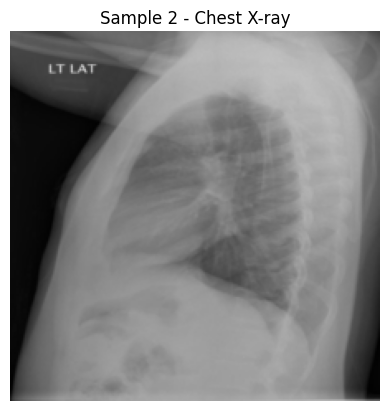

Sample 2
Ground Truth Report:
 The heart size is normal. Lungs are clear. There is no pleural line to suggest pneumothorax or costophrenic XXXX blunting to suggest large pleural effusion. Bony structures are within normal limits. No acute cardiopulmonary findings.

Generated Report:
 The cardiomediastinal silhouette is normal in size and configuration. There is no pneumothorax or large pleural effusion. No acute cardiopulmonary abnormality.
--------------------------------------------------------------------------------


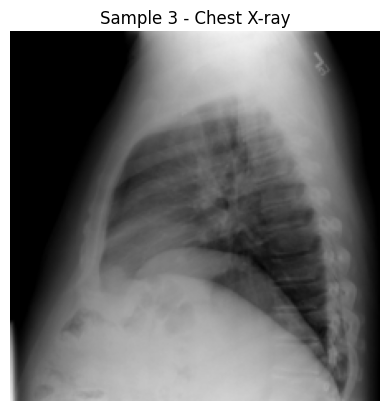

Sample 3
Ground Truth Report:
 There is a 1.5 cm nodular opacity projecting over left hilum. The cardiac silhouette is within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of pleural effusion. There is no evidence of pneumothorax. XXXX opacities XXXX representing surgical clips, in the midline at the level of the thoracic inlet. 1. Prominence of left hilum which could be due to nodule/lymph node or superimposing blood XXXX. In the absence of prior studies for comparison, XXXX chest for further evaluation. Result notification XXXX Primordial.

Generated Report:
 Heart size normal. Lungs clear. No effusions or pneumothoraces. No acute cardiopulmonary findings.
--------------------------------------------------------------------------------


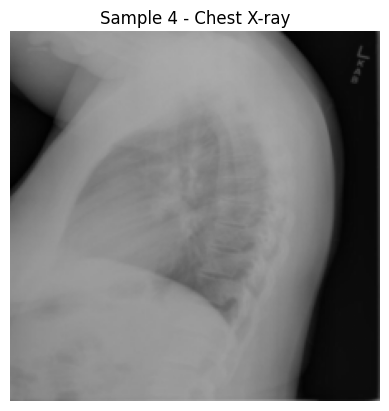

Sample 4
Ground Truth Report:
 The heart is normal in size with normal appearance of the cardiomediastinal silhouette. The lungs are clear without focal airspace opacity, pleural effusion, or pneumothorax. The osseous structures are intact, with mild degenerative changes in the thoracic spine. No acute cardiopulmonary finding.

Generated Report:
 The cardiomediastinal silhouette is normal in size and contour. The lungs are well aerated. No pleural effusions or pneumothoraces. No acute cardiopulmonary abnormalities.
--------------------------------------------------------------------------------


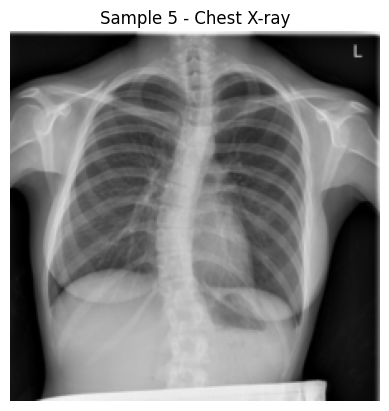

Sample 5
Ground Truth Report:
 Lungs are clear. No pleural effusions or pneumothoraces. Heart and mediastinum of normal size and contour. scoliosis. Clear lungs.

Generated Report:
 S examination consists of frontal and lateral radiographs of the chest. The cardiac silhouette is within normal limits for size and contour. There are small rounded pulmonary nodules in the posterior right lung base. There is no focal consolidation, pleural effusion, or pneumothorax. Visualized osseous structures are intact. No acute cardiopulmonary disease.
--------------------------------------------------------------------------------


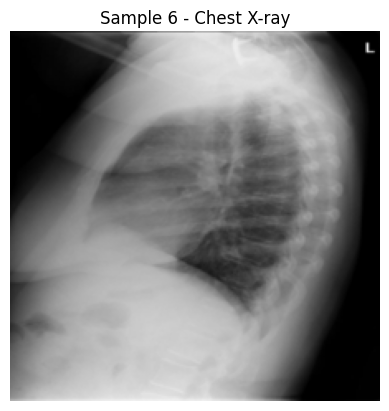

Sample 6
Ground Truth Report:
 Mediastinal contours are within normal limits. Heart size is within normal limits. No focal consolidation, pneumothorax or pleural effusion. Cervical fusion XXXX. Degenerative changes of the spine and the acromioclavicular joints. No acute cardiopulmonary abnormality.

Generated Report:
 Heart size is normal. Lungs are clear. Calcified mediastinal lymph XXXX are normal. No pneumonia, effusions, edema, pneumothorax, adenopathy, nodules or masses. Normal chest
--------------------------------------------------------------------------------


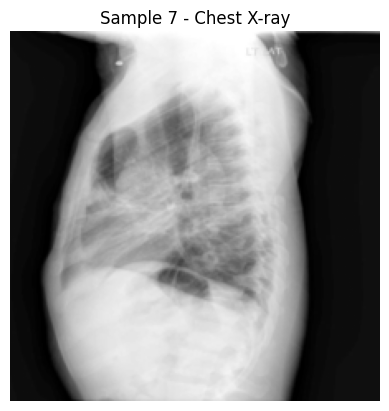

Sample 7
Ground Truth Report:
 The heart size is normal. The mediastinal contour is within normal limits. There is a streaky opacity within the right upper lobe. There are no nodules or masses. No visible pneumothorax. No visible pleural fluid. The XXXX are grossly normal. There is no visible free intraperitoneal air under the diaphragm. Right upper lobe infiltrate consistent with pneumonia.

Generated Report:
 The heart size is normal. The mediastinal contours are within normal limits. Lungs are expanded and clear. No active disease.
--------------------------------------------------------------------------------


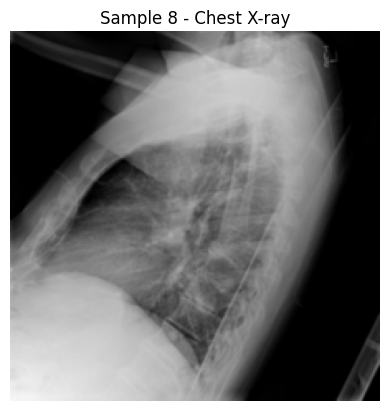

Sample 8
Ground Truth Report:
 The heart size of the limits of normal. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. There is a calcified granuloma right midlung and posterior costophrenic sulcus. No acute cardiopulmonary abnormality.

Generated Report:
 Stable right at the top. The cardiac silhouette is normal. An overlying calcified granuloma is seen within the right upper lobe, also present on the PA view. No pneumothorax or pleural effusion. The heart size is within normal limits. No focal air space opacity to suggest an acute osseous fracture. No acute cardiopulmonary findings. .
--------------------------------------------------------------------------------


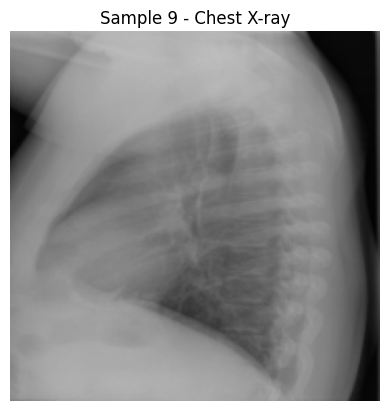

Sample 9
Ground Truth Report:
 Heart size normal. Lungs clear. Calcified 5 mm right upper lobe granuloma.

Generated Report:
 No focal infiltrates. Heart size normal. Mediastinal contour within normal limits. No visible perihilar consolidation or pleural effusion. No visible adenopathy. Hyperexpanded lungs. No acute cardiopulmonary abnormality. .
--------------------------------------------------------------------------------


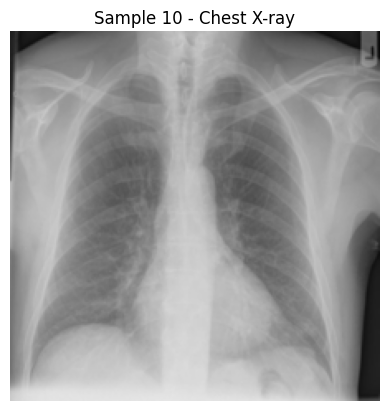

Sample 10
Ground Truth Report:
 Heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. There is mild prominence of the interstitial markings which are unchanged. 1. No evidence of acute disease.

Generated Report:
 The heart size is normal in size and contour. The lungs are clear bilaterally, without evidence of effusion or pneumothorax. There are no acute bony findings. No acute cardiopulmonary findings.
--------------------------------------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer
import torch
from torch.nn.functional import softmax

# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Load the latest checkpoint
ckpt_path = "/content/drive/MyDrive/Colab Notebooks/HC Assignments/Final Project/CKP/model_epoch5.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model = model.to(device)
model.eval()

# Top-k sampling generation
def generate_with_sampling(model, img_embedding, tokenizer, max_len=128, top_k=50, temperature=1.0):
    input_ids = None
    generated = []

    for _ in range(max_len):
        if input_ids is None:
            inputs = img_embedding
        else:
            text_embed = model.gpt.transformer.wte(input_ids)
            inputs = torch.cat([img_embedding, text_embed], dim=1)

        with torch.no_grad():
            logits = model.gpt(inputs_embeds=inputs).logits[:, -1, :]
            logits = logits / temperature
            probs = softmax(logits, dim=-1)

            topk_probs, topk_indices = torch.topk(probs, top_k)
            next_token = topk_indices[0, torch.multinomial(topk_probs[0], 1)].unsqueeze(0)

        if next_token.item() == tokenizer.eos_token_id:
            break

        generated.append(next_token.item())
        input_ids = next_token if input_ids is None else torch.cat([input_ids, next_token], dim=1)

    return tokenizer.decode(generated, skip_special_tokens=True)

# Loop through 10 samples
for idx in range(10):
    sample = val_dataset[idx]
    image = sample["image"].unsqueeze(0).to(device)
    gt_report = sample["caption"]

    # Encode image
    with torch.no_grad():
        feats = model.cnn(image)
        feats = feats.view(1, -1)
        img_embedding = model.img_proj(feats).unsqueeze(1)

    # Generate report using Top-k Sampling
    gen_report = generate_with_sampling(model, img_embedding, tokenizer, max_len=128, top_k=50, temperature=1.0)

    # Show image
    plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu() * 0.5 + 0.5)
    plt.axis('off')
    plt.title(f"Sample {idx+1} - Chest X-ray")
    plt.show()

    print(f"Sample {idx+1}")
    print("Ground Truth Report:\n", gt_report)
    print("\nGenerated Report:\n", gen_report)
    print("-" * 80)


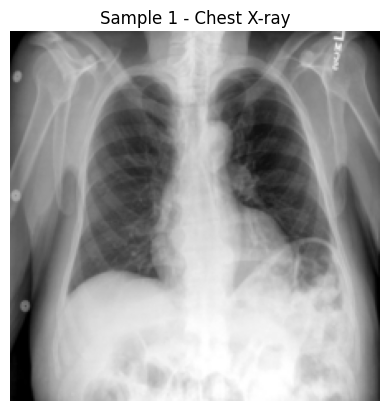

✅ Sample 1
🩻 Ground Truth Report:
 The heart is near top normal in size with tortuosity of the aorta. The pulmonary vascular markings are symmetric and normal. There are low lung volumes with XXXX opacities consistent with focal atelectasis. There is no pleural effusion or pneumothorax. There are degenerative changes in thoracic spine and thoracic kyphosis. Low lung volumes with XXXX opacities consistent with focal atelectasis.

🤖 Generated Report:
 The lungs are hyperexpanded. There is no pleural effusion or pneumothorax. Cardiomediastinal silhouette is within normal limits. Lungs are hyperexpanded with no acute abnormality identified. No acute pulmonary abnormality identified. .
--------------------------------------------------------------------------------


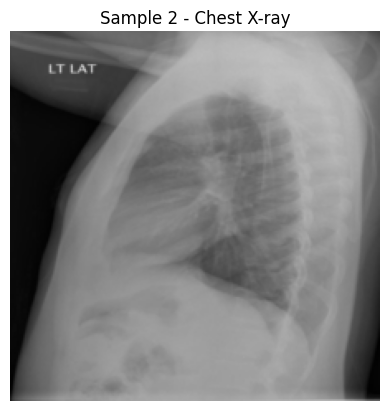

✅ Sample 2
🩻 Ground Truth Report:
 The heart size is normal. Lungs are clear. There is no pleural line to suggest pneumothorax or costophrenic XXXX blunting to suggest large pleural effusion. Bony structures are within normal limits. No acute cardiopulmonary findings.

🤖 Generated Report:
 Lungs are clear bilaterally. No pleural effusion or pneumothoraces. Heart and mediastinum of normal size and contour. Clear lungs bilaterally.
--------------------------------------------------------------------------------


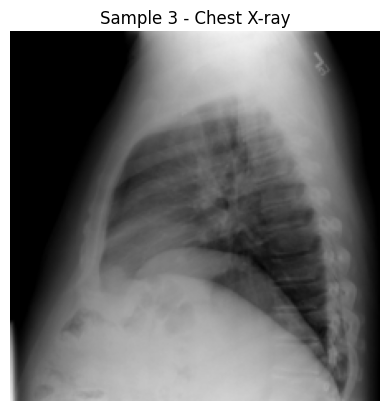

✅ Sample 3
🩻 Ground Truth Report:
 There is a 1.5 cm nodular opacity projecting over left hilum. The cardiac silhouette is within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of pleural effusion. There is no evidence of pneumothorax. XXXX opacities XXXX representing surgical clips, in the midline at the level of the thoracic inlet. 1. Prominence of left hilum which could be due to nodule/lymph node or superimposing blood XXXX. In the absence of prior studies for comparison, XXXX chest for further evaluation. Result notification XXXX Primordial.

🤖 Generated Report:
 The trachea is midline. The cardiomediastinal silhouette is normal. Right lower lobe airspace disease.
--------------------------------------------------------------------------------


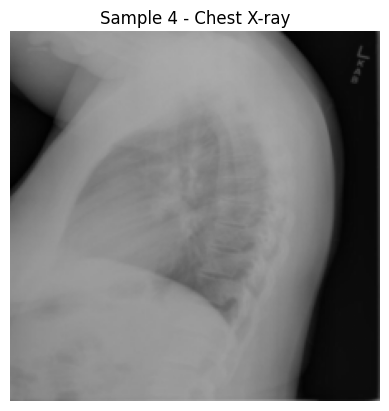

✅ Sample 4
🩻 Ground Truth Report:
 The heart is normal in size with normal appearance of the cardiomediastinal silhouette. The lungs are clear without focal airspace opacity, pleural effusion, or pneumothorax. The osseous structures are intact, with mild degenerative changes in the thoracic spine. No acute cardiopulmonary finding.

🤖 Generated Report:
 H. Clear lungs. No edema. No focal airspace disease, effusions, or pneumothorax. No displaced rib fractures. Mild degenerative disc disease of the spine. Clear lungs. Unremarkable cardiomediastinal silhouette without acute bony abnormalities.
--------------------------------------------------------------------------------


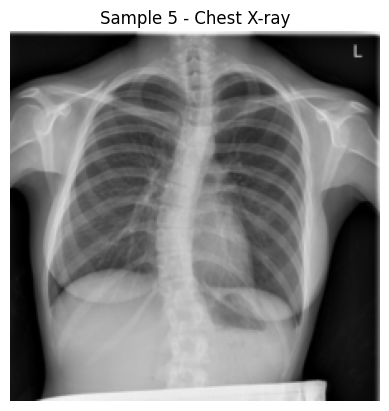

✅ Sample 5
🩻 Ground Truth Report:
 Lungs are clear. No pleural effusions or pneumothoraces. Heart and mediastinum of normal size and contour. scoliosis. Clear lungs.

🤖 Generated Report:
 Heart size normal. Lungs are clear. XXXX are normal. No pneumonia, effusions, edema, pneumothorax, adenopathy, nodules or masses. Normal chest
--------------------------------------------------------------------------------


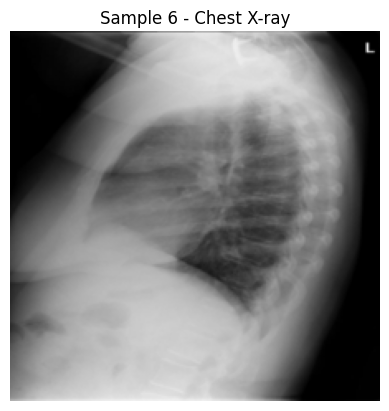

✅ Sample 6
🩻 Ground Truth Report:
 Mediastinal contours are within normal limits. Heart size is within normal limits. No focal consolidation, pneumothorax or pleural effusion. Cervical fusion XXXX. Degenerative changes of the spine and the acromioclavicular joints. No acute cardiopulmonary abnormality.

🤖 Generated Report:
 The heart is normal in size. The mediastinum is unremarkable. The lungs are hypoinflated. No acute disease.
--------------------------------------------------------------------------------


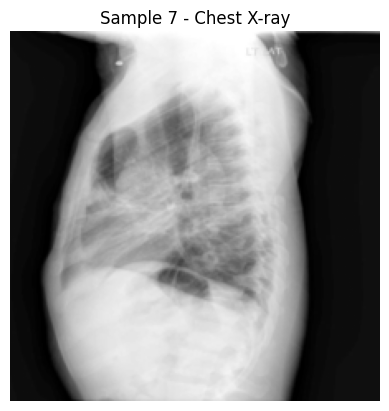

✅ Sample 7
🩻 Ground Truth Report:
 The heart size is normal. The mediastinal contour is within normal limits. There is a streaky opacity within the right upper lobe. There are no nodules or masses. No visible pneumothorax. No visible pleural fluid. The XXXX are grossly normal. There is no visible free intraperitoneal air under the diaphragm. Right upper lobe infiltrate consistent with pneumonia.

🤖 Generated Report:
 S is increased. Lung volumes are low. No infiltrates are present. Heart and pulmonary XXXX XXXX are normal. The patient is status post XXXX. Lung volumes are high with minimal pulmonary disease.
--------------------------------------------------------------------------------


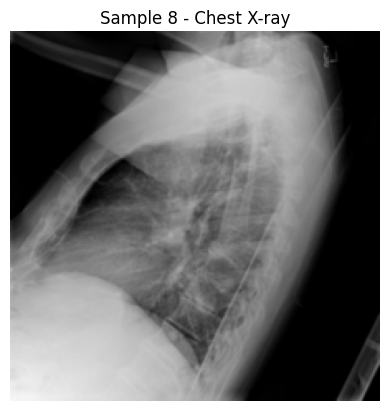

✅ Sample 8
🩻 Ground Truth Report:
 The heart size of the limits of normal. There is no pneumothorax or pleural effusion. There are no focal areas of consolidation. There is a calcified granuloma right midlung and posterior costophrenic sulcus. No acute cardiopulmonary abnormality.

🤖 Generated Report:
 The heart size is normal, but cardiomediastinal silhouette is normal in size. The lungs are clear (frontal and lateral views) without evidence of acute infiltrate or effusion. There are no pneumothorax. There is loss of XXXX XXXX left clavicle. Normal pulmonary vasculature with vascular congestion. No acute cardiopulmonary abnormalities.
--------------------------------------------------------------------------------


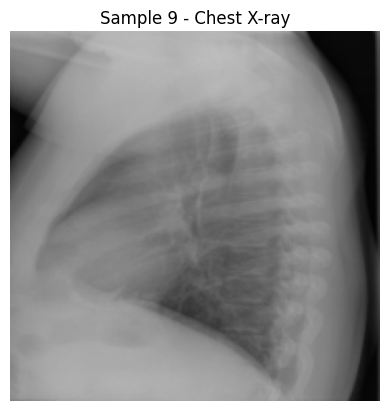

✅ Sample 9
🩻 Ground Truth Report:
 Heart size normal. Lungs clear. Calcified 5 mm right upper lobe granuloma.

🤖 Generated Report:
 The lungs are clear bilaterally. Specifically, no evidence of focal consolidation, pneumothorax, or pleural effusion.. Cardiomediastinal silhouette is within normal limits. Visualized osseous structures of the thorax appear intact. No acute cardiopulmonary abnormality..
--------------------------------------------------------------------------------


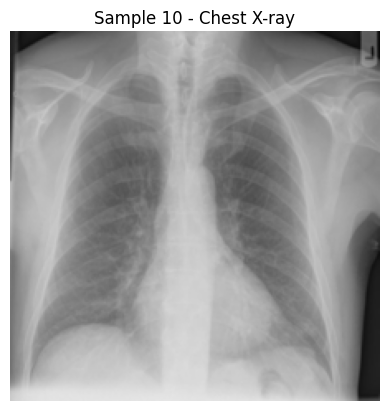

✅ Sample 10
🩻 Ground Truth Report:
 Heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. There is mild prominence of the interstitial markings which are unchanged. 1. No evidence of acute disease.

🤖 Generated Report:
 Heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. No evidence of active disease.
--------------------------------------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer
import torch
from torch.nn.functional import softmax

# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Load checkpoint
ckpt_path = "/content/drive/MyDrive/Colab Notebooks/HC Assignments/Final Project/CKP/model_epoch5.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model = model.to(device)
model.eval()

# Top-k sampling generation function
def generate_with_sampling(model, img_embedding, tokenizer, max_len=128, top_k=50, temperature=1.0):
    input_ids = None
    generated = []

    for _ in range(max_len):
        if input_ids is None:
            inputs = img_embedding
        else:
            text_embed = model.gpt.transformer.wte(input_ids)
            inputs = torch.cat([img_embedding, text_embed], dim=1)

        with torch.no_grad():
            logits = model.gpt(inputs_embeds=inputs).logits[:, -1, :]
            logits = logits / temperature
            probs = softmax(logits, dim=-1)
            topk_probs, topk_indices = torch.topk(probs, top_k)
            next_token = topk_indices[0, torch.multinomial(topk_probs[0], 1)].unsqueeze(0)

        if next_token.item() == tokenizer.eos_token_id:
            break

        generated.append(next_token.item())
        input_ids = next_token if input_ids is None else torch.cat([input_ids, next_token], dim=1)

    return tokenizer.decode(generated, skip_special_tokens=True)

# Run on 10 samples
for idx in range(10):
    sample = val_dataset[idx]
    image = sample["image"].unsqueeze(0).to(device)
    gt_report = sample["caption"]

    with torch.no_grad():
        feats = model.cnn(image)
        feats = feats.view(1, -1)
        img_embedding = model.img_proj(feats).unsqueeze(1)

    gen_report = generate_with_sampling(model, img_embedding, tokenizer)

    # Show image
    plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu() * 0.5 + 0.5)
    plt.axis('off')
    plt.title(f"Sample {idx+1} - Chest X-ray")
    plt.show()

    print(f"✅ Sample {idx+1}")
    print("🩻 Ground Truth Report:\n", gt_report.strip())
    print("\n🤖 Generated Report:\n", gen_report.strip())
    print("-" * 80)


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from tqdm import tqdm

generated_reports = []
ground_truth_reports = []

print("🔍 Generating reports for evaluation...")
for idx in tqdm(range(len(val_dataset)), desc="Generating Samples"):
    sample = val_dataset[idx]
    image = sample["image"].unsqueeze(0).to(device)
    gt_report = sample["caption"]

    with torch.no_grad():
        feats = model.cnn(image)
        feats = feats.view(1, -1)
        img_embedding = model.img_proj(feats).unsqueeze(1)

    gen_report = generate_with_sampling(model, img_embedding, tokenizer)
    ground_truth_reports.append(gt_report)
    generated_reports.append(gen_report)

bleu1_scores = []
bleu4_scores = []
meteor_scores = []
rouge_l_scores = []

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
smooth = SmoothingFunction().method1

print("📊 Evaluating text similarity metrics...")
for ref, hyp in tqdm(zip(ground_truth_reports, generated_reports), total=len(val_dataset), desc="Evaluating"):
    ref_tokens = nltk.word_tokenize(ref.lower())
    hyp_tokens = nltk.word_tokenize(hyp.lower())

    bleu1_scores.append(sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth))
    bleu4_scores.append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth))
    meteor_scores.append(meteor_score([ref_tokens], hyp_tokens))
    rouge_l_scores.append(scorer.score(ref, hyp)["rougeL"].fmeasure)

print(f"\n✅ Final Evaluation on {len(val_dataset)} Validation Samples")
print(f"BLEU-1 Score:   {sum(bleu1_scores) / len(bleu1_scores):.4f}")
print(f"BLEU-4 Score:   {sum(bleu4_scores) / len(bleu4_scores):.4f}")
print(f"METEOR Score:   {sum(meteor_scores) / len(meteor_scores):.4f}")
print(f"ROUGE-L Score:  {sum(rouge_l_scores) / len(rouge_l_scores):.4f}")

🔍 Generating reports for evaluation...


Generating Samples: 100%|██████████| 766/766 [09:48<00:00,  1.30it/s]


📊 Evaluating text similarity metrics...


Evaluating: 100%|██████████| 766/766 [00:03<00:00, 251.84it/s]


✅ Final Evaluation on 766 Validation Samples
BLEU-1 Score:   0.3140
BLEU-4 Score:   0.0811
METEOR Score:   0.3034
ROUGE-L Score:  0.2569


## **Final Project Summary**

This project focuses on **automated medical report generation from chest X-ray images** using a hybrid model that combines a **ResNet50 CNN encoder** with a **GPT-2 language decoder**. Leveraging the IU Chest X-ray dataset, the objective was to generate clinically meaningful and semantically fluent radiology reports based solely on input images, aiming to assist radiologists by automating part of the report writing process.

### Model Design

- **Visual Encoder**: A pretrained ResNet50 model was used to extract deep visual features from grayscale chest X-rays. The last two layers were removed to output a spatial feature map, which was flattened and projected into the same dimensionality as GPT-2 token embeddings.
- **Text Decoder**: GPT-2 was adapted for sequence generation. Only the last two transformer blocks were unfrozen for efficient fine-tuning, mitigating overfitting on small datasets.
- **Fusion Strategy**: An image embedding token (with positional encoding) was prepended to the textual tokens, enabling GPT-2 to generate reports conditioned on the visual context.

### Training & Evaluation

- **Dataset**: 3,060 training and 766 validation samples from the IU Chest X-ray dataset.
- **Training Details**: The model was trained for **15+5 epochs**, using Adam optimizer and a batch size of 16. Final training and validation losses were:
  - **Final Training Loss**: `0.5281`
  - **Final Validation Loss**: `0.6040`

- **Text Generation Strategy**: Top-k sampling (k=50) with temperature 1.0 was used to enhance generation diversity while maintaining coherence.

- **Quantitative Evaluation on 766 Samples**:
  - **BLEU-1**: `0.3140`
  - **BLEU-4**: `0.0811`
  - **METEOR**: `0.3034`
  - **ROUGE-L**: `0.2569`

These metrics indicate that the model captures medically relevant content to a moderate degree, generating grammatically fluent but often generalized reports.

### Qualitative Results

- The generated reports are generally **clinically safe** (e.g., "no focal consolidation", "heart size normal"), but often **repetitive** and **lacking rare abnormalities**.
- The decoder tends to **default to common templates** without enough variability or nuanced findings seen in ground truth reports.
- Despite limitations, the model maintains a decent **semantic alignment** with input images.

---

## **Future Work**

To further enhance model performance and clinical utility, the following directions are suggested:

1. **Report Structure Modeling**  
   Introduce hierarchical or section-aware decoders to explicitly generate Impression, Findings, and Observation sections separately.

2. **Multi-View Learning**  
   Incorporate both frontal and lateral views to improve context understanding and abnormality detection.

3. **Domain-Specific Pretraining**  
   Replace GPT-2 with a **biomedical language model** (e.g., BioGPT or ClinicalBERT decoder) better suited to medical vocabulary and style.

4. **Reinforcement Learning from Human Feedback (RLHF)**  
   Use clinical acceptability ratings to optimize report fluency, correctness, and completeness.

5. **Integration with Retrieval-Augmented Generation**  
   Retrieve similar past cases from a database to guide generation or enrich the latent space.

---

**In summary**, this project successfully demonstrates an image-to-text generation pipeline for medical report generation and sets a strong foundation for building **safe, interpretable, and intelligent radiology assistants**.
